In [1]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sn
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
# NLP
from nltk.corpus import stopwords
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # bag of words, tfifd
# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Read Data

This data comes from https://www.kaggle.com/c/learn-ai-bbc/data

In [2]:
home_path = os.path.expanduser("~")
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)
df.head(2)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


### Exploratory Data Analysis

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

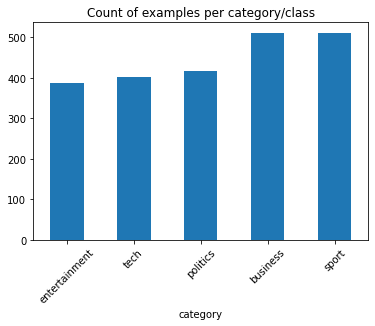

In [3]:
(f'Number of documents in dataset: {len(df)}')
display(df['category'].value_counts()/df.shape[0]) # Class distribution in the dataset
df.groupby('category').size().sort_values().plot.bar()
plt.title('Count of examples per category/class')
plt.xticks(rotation=45);

Business and Sport are best represented in the dataset.

### How good is a baseline logistic regression model on the raw dataset?

In [4]:
def plot_confusion_matrix(cm, classes, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()

CPU times: user 10.8 s, sys: 12.2 s, total: 23 s
Wall time: 3.65 s
Accuracy Training Data:  1.0


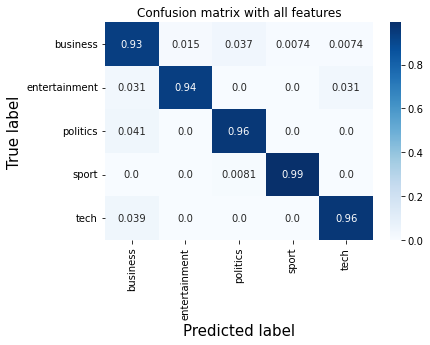

Accuracy Test Data:  0.9569120287253142


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], 
                                                    test_size=0.25, random_state=42)

log_reg = Pipeline([('bow', CountVectorizer(binary=True)), 
                   ('clf', LogisticRegression(random_state=42))])
%time log_reg.fit(X_train, y_train)
y_pred_training_data = log_reg.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

# Test Model
y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy Test Data: ", accuracy_score(y_true=y_test, y_pred=y_pred))

### Preprocessing
lowercase strings, remove digits, punctuation, stopwords, and lemmatise.

When saving pandas dataframes as csv the list object is stored as a string, therefore the `ast.literal_eval` function converts it back to a list. Save as pickle to keep data types.

In [6]:
# Install the spaCy language model
# ! python -m spacy download en_core_web_sm

This script take ~30mins the first time.

In [9]:
%%time
mystopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
def clean(doc):
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()]) # remove punctuation and numbers
    doc = " ".join([token.lower() for token in doc.split() if token not in mystopwords])
    doc = " ".join([w.lemma_ for word in doc.split() for w in nlp(word)])
    return doc

df_preprop_fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text-preprocessed.csv'
if not os.path.exists(df_preprop_fp):
    df['prepro'] = df['text'].apply(clean)
    df.to_csv(df_preprop_fp, index=False)
    
else: # load preprocessed(lemmatisated) dataframe
    df = pd.read_csv(df_preprop_fp)
#     df['prepro'] = df['prepro'].apply(ast.literal_eval) # convert str to list

CPU times: user 319 ms, sys: 219 ms, total: 538 ms
Wall time: 543 ms


In [10]:
display(df.head(2))

,category,text,prepro
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom boss leave book alone former worldcom...


### Model Training & Testing

#### LOGISTIC REGRESSION
Logistic regression is an example of a discriminative classifier and is commonly used in text classification, as a baseline in research, and as an MVP in real-world industry scenarios. Logistic regression “learns” the weights for individual features based on how important they are. The goal of logistic regression is to learn a linear separator between classes in the training data with the aim of maximizing the probability of the data. This “learning” of feature weights and probability distribution over all classes is done through a function called “logistic” function, and (hence the name) logistic regression. (Vajjala et al, Practical Natural Language Processing)

#### Bag of words vectoriser

CPU times: user 7.4 s, sys: 7.37 s, total: 14.8 s
Wall time: 2.26 s
Accuracy Training Data:  1.0


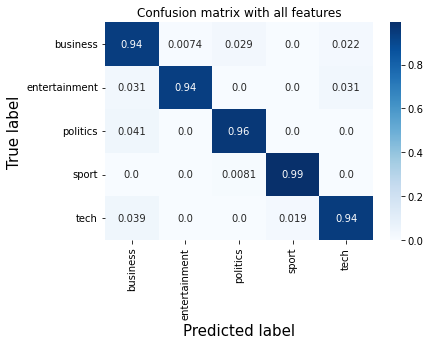

Accuracy Test Data:  0.9551166965888689


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['prepro'], df['category'], 
                                                    test_size=0.25, random_state=42)

log_reg = Pipeline([('bow', CountVectorizer(binary=True)), 
                   ('clf', LogisticRegression(random_state=42, class_weight='balanced'))])
%time log_reg.fit(X_train, y_train)
y_pred_training_data = log_reg.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

# Test Model
y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy Test Data: ", accuracy_score(y_true=y_test, y_pred=y_pred))

#### Term frequency inverse document frequency as the data vectoriser:

CPU times: user 5.13 s, sys: 5.78 s, total: 10.9 s
Wall time: 1.97 s
Accuracy Training Data:  0.9964028776978417


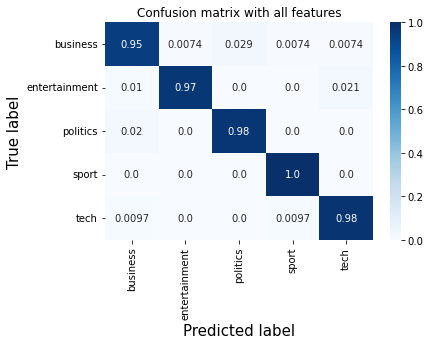

Accuracy Test Data:  0.9748653500897666


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['prepro'], df['category'], 
                                                    test_size=0.25, random_state=42)

log_reg = Pipeline([('tfidf', TfidfVectorizer()), 
                   ('clf', LogisticRegression(random_state=42, class_weight='balanced'))])
%time log_reg.fit(X_train, y_train)
y_pred_training_data = log_reg.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

# Test Model
y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy Test Data: ", accuracy_score(y_true=y_test, y_pred=y_pred))

Term frequency inverse document frequency does much better. 

#### Let's have a quick look at what the vector data looks like for bow and tfidf

In [18]:
count_vect = CountVectorizer(binary=True)
vec = count_vect.fit_transform(df['prepro'].astype(str))
# create dataframe
df_vec = pd.DataFrame(vec.toarray(), columns=count_vect.get_feature_names())
print(f'There are {len(df_vec.columns)} tokens in the bag of words')
display(df_vec.sample(5, random_state=4))

There are 23431 tokens in the bag of words


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1862,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
count_vect = TfidfVectorizer()
vec = count_vect.fit_transform(df['prepro'].astype(str))
# create dataframe
df_vec = pd.DataFrame(vec.toarray(), columns=count_vect.get_feature_names())
print(f'There are {len(df_vec.columns)} tokens in the tfidf')
display(df_vec.sample(5, random_state=4))

There are 23431 tokens in the tfidf


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
675,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1997,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1862,0.0,0.0,0.133944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2218,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.102785,0.0,0.0,0.0
2089,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### Hyperparameter Tuning

GridSearchCV: hyperparameter tuning in order to determine the optimal values for a given model

Defaults: `C = 10`, `solver = 'lbfgs`, `max_iter = 100`

source: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

In [31]:
%%time
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                   ('clf', LogisticRegression(random_state=42, class_weight='balanced'))])
param_grid = {"clf__C": np.logspace(-1,2,4),
             "clf__solver": ['lbfgs', 'newton-cg', 'liblinear']}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)  # -1 means process on all CPU cores
grid.fit(X_train,y_train)

print(f'Accuracy {grid.best_score_}')
print(f'Tuned hpyerparameters : {grid.best_params_}')

Accuracy 0.9802214847413607
Tuned hpyerparameters : {'clf__C': 10.0, 'clf__solver': 'lbfgs'}
CPU times: user 11.7 s, sys: 11.9 s, total: 23.6 s
Wall time: 35.4 s


Looks like this is as good as we will get with logistic regression. 

In [37]:
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.sort_values(by='mean_test_score', ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,5.024962,0.468069,0.091275,0.019576,10.0,lbfgs,"{'clf__C': 10.0, 'clf__solver': 'lbfgs'}",0.976048,0.964072,0.964072,0.994012,0.976048,0.988024,0.988024,0.982036,0.981928,0.987952,0.980221,0.009666,1
7,2.098574,0.320227,0.087109,0.023351,10.0,newton-cg,"{'clf__C': 10.0, 'clf__solver': 'newton-cg'}",0.976048,0.964072,0.964072,0.994012,0.976048,0.988024,0.988024,0.982036,0.981928,0.987952,0.980221,0.009666,1
11,0.985630,0.121128,0.049930,0.013899,100.0,liblinear,"{'clf__C': 100.0, 'clf__solver': 'liblinear'}",0.970060,0.964072,0.964072,0.994012,0.976048,0.994012,0.988024,0.982036,0.981928,0.987952,0.980221,0.010721,1


Looks like the newton-cg solver does just as well as the lbfgs with C=10

### Visualisation of word vectors in 2D with TSNE

In [39]:
from sklearn.manifold import TSNE

Fit the tsne model to the transposed pandas dataframe so that each unique word is a row (rather than column)

In [69]:
df_vec_sample = df_vec.T.sample(1000, random_state=42)
words = df_vec_sample.index

In [70]:
%%time
print(df_vec_sample.shape)  # (word tokens, documents)
tsne_model = TSNE(random_state=42)
tsne_data = tsne_model.fit_transform(df_vec_sample)  # take a sample otherwise too many words
print(tsne_data.shape)

(1000, 2225)
(1000, 2)
CPU times: user 25.2 s, sys: 1.66 s, total: 26.8 s
Wall time: 3.46 s


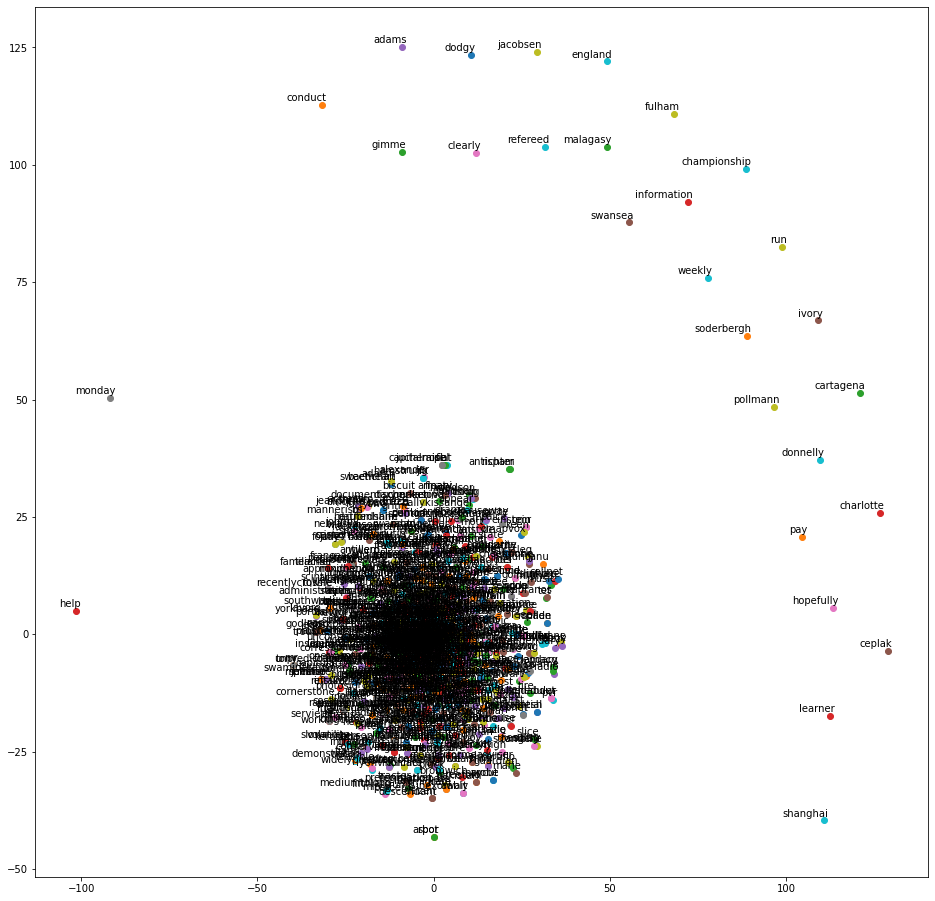

CPU times: user 14 s, sys: 519 ms, total: 14.6 s
Wall time: 14.3 s


In [71]:
%%time
x = []
y = []
for value in tsne_data:
    x.append(value[0])
    y.append(value[1])
    
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5,2), 
                 textcoords='offset points', ha='right', va='bottom')
plt.show()

#### Visualise the clusters of classes

In [77]:
df_vec['category_label'] = df['category']

In [78]:
df_vec.head()

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev,category_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tech
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,business
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sport
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sport
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,entertainment


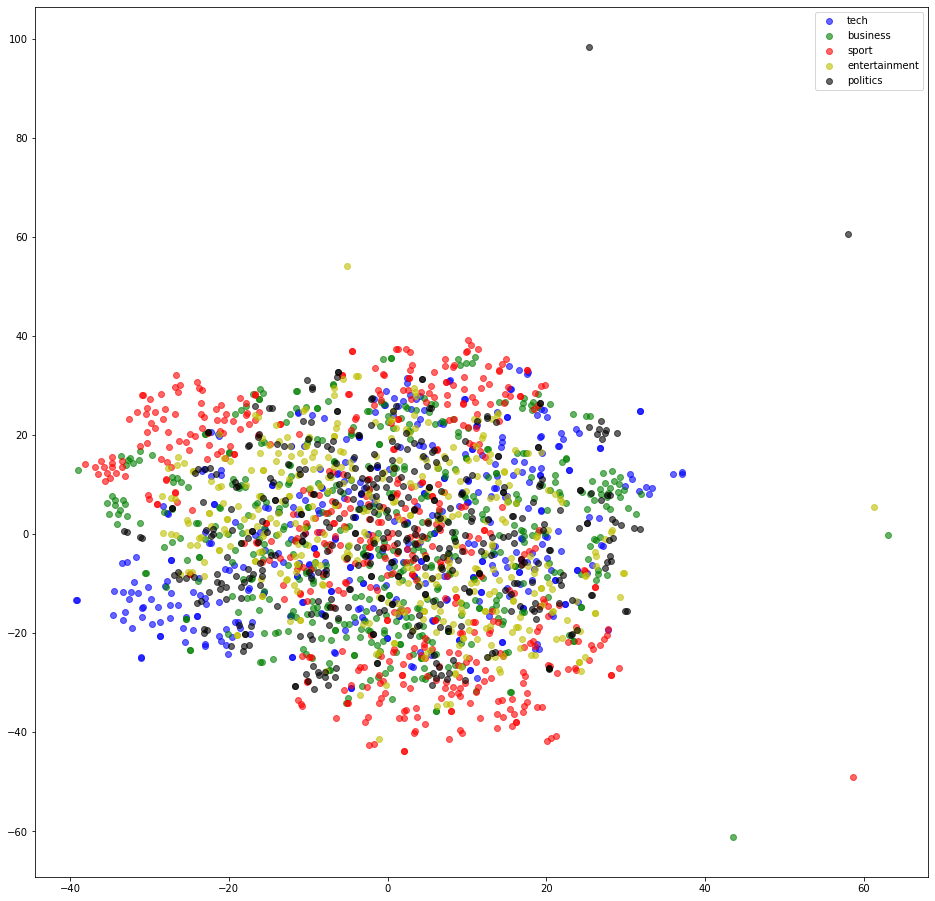

CPU times: user 58.7 s, sys: 4.93 s, total: 1min 3s
Wall time: 8.44 s


In [87]:
%%time
categories = df_vec['category_label'].unique()
colors = ['b', 'g', 'r', 'y', 'k']
plt.figure(figsize=(16, 16)) 
for num, category in enumerate(categories):
    color = colors[num]
    df_cat = df_vec[df_vec['category_label'] == category]
    df_cat = df_cat.drop('category_label', axis=1)
    tsne_model = TSNE(random_state=42)
    tsne_data = tsne_model.fit_transform(df_cat)  # data not transposed this time... interested in document clusters
    x, y = zip(*tsne_data)
    plt.scatter(x, y, color=color, alpha=0.6, label=category)
plt.legend()
plt.show()